# Bias Variance Tradeoff

This notebook explores the bias variance trade-off in machine learning. For more background knowledge, there are plenty of good resources online, such as this one: http://scott.fortmann-roe.com/docs/BiasVariance.html

The expected squared prediction error at a point $x$ is given by the following formula:


\begin{align}
\text{Expected squared prediction error}
& = \textit{Err}(x) \\
& = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error} \\
& = \left(E\left[\hat{f}(x)\right] - f(x)\right)^2 + E\left[\left(\hat{f}(x) - E[\hat{f}(x)]\right)^2\right] + \sigma^2_e
\end{align}

The error can be split into the bias and variance components. The third term is irreducible error from noise that cannot be fundamentally reduced by any model.


$f(x)=0.2x^{5}-3.5x^{4}+21x^{3}-53x^{2}+37x+0.6$

In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

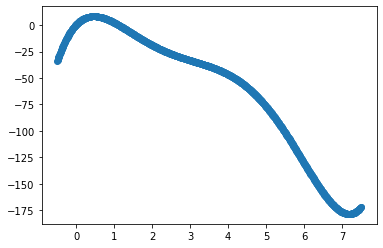

In [3]:
X = np.linspace(-0.5,7.5, 1000)

# shuffle the order so that we can randomly split into training and validation data
np.random.shuffle(X)
y = 0.2*X**5 - 3.5*X**4 + 21*X**3 - 53*X**2 + 37*X + 0.6
plt.scatter(X, y)

Simulate training data by introducing random errors on the curve.

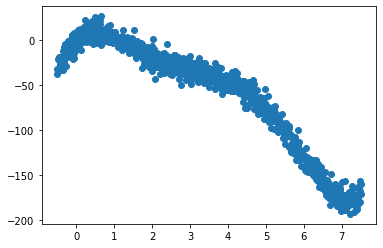

In [4]:
mu, sigma = 0, 7 
noise = np.random.normal(mu, sigma, [1000,])
y_noise = y + noise
plt.scatter(X, y_noise)

(200,)


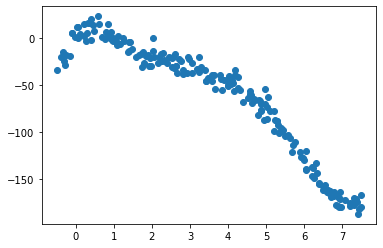

In [5]:
# Out of 1,000 datapoints, use 200 for validation set
X_valid = X[800:]
y_valid = y_noise[800:]
print(X_valid.shape)
plt.scatter(X_valid, y_valid)

In [6]:
# Out of 1,000 datapoints, use 800 for training set
X_train = X[0:799]
y_train = y_noise[0:799]

# reshape X_valid
X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
X_valid = X_valid.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)

Using the remaining data, build 500 linear regression models, each by randomly sampling 80 observations from the pool:

In [7]:
# create a 200x1 array of the actual Y value for each row of X_valid data
truth = 0.2*X_valid**5 - 3.5*X_valid**4 + 21*X_valid**3 - 53*X_valid**2 + 37*X_valid + 0.6
truth.shape

(200, 1)

In [8]:
# returns a 200x500 array where one row is for each X_valid data, and 500 for each randomly created sample
def get_estimates(deg):
    estimates=[[]]

    for i in range(500):

        # randomly get 80 indexes from total size of x_train 
        idx=np.random.choice(np.arange(0,len(X_train)), size=80)

        # create random sample of 80 observations
        X = (X_train[idx]).reshape(-1, 1)
        y = (y_train[idx]).reshape(-1, 1)

        polynomial_features = PolynomialFeatures(degree=deg)
        x_poly = polynomial_features.fit_transform(X)
        x_poly_valid = polynomial_features.fit_transform(X_valid)

        model = LinearRegression()
        model.fit(x_poly, y)
        y_pred = model.predict(x_poly_valid)

        # estimates will first be (200, 1), then (200, 2) till (200, 500) 
        if i==0:
            estimates = y_pred
        else:
            estimates = np.hstack((estimates, y_pred))
    return estimates

In [9]:
# returns the bias when passed an estimates array and truth array
def get_bias_sq(estimates, truth):
    bias_list = []
    for row in range(len(X_valid)):
        bias = np.mean(estimates[row]) - truth[row]
        bias_list.append(bias)
        
    # square before taking mean    
    bias_sq_list = [i**2 for i in bias_list]
    
    # return the averaged bias for all 200 rows of X_valid data
    return np.mean(bias_sq_list)

In [10]:
# returns the variance when passed an estimates array and truth array
def get_var(estimates):
    var_list = []
    for row in range(len(X_valid)):
        var = np.mean((estimates[row]-np.mean(estimates[row]))**2)
        var_list.append(var)
    
    # return the averaged var for all 200 rows of X_valid data
    return np.mean(var_list)

In [11]:
# returns the MSE when passed an estimates array and truth array
def get_mse(estimates, truth):
    mse_list = []
    for row in range(len(X_valid)):
        mse = np.mean((estimates[row] - truth[row])**2)
        mse_list.append(mse)
    
    # return the averaged bias for all 200 rows of X_valid data
    return np.mean(mse_list)

In [18]:
bias_sq = []
variance = []
mse = []

np.random.seed(30)

for i in range(1, 16):
    estimates = get_estimates(i)
    bias_sq.append(get_bias_sq(estimates, truth))
    variance.append(get_var(estimates))
    mse.append(get_mse(estimates, truth))

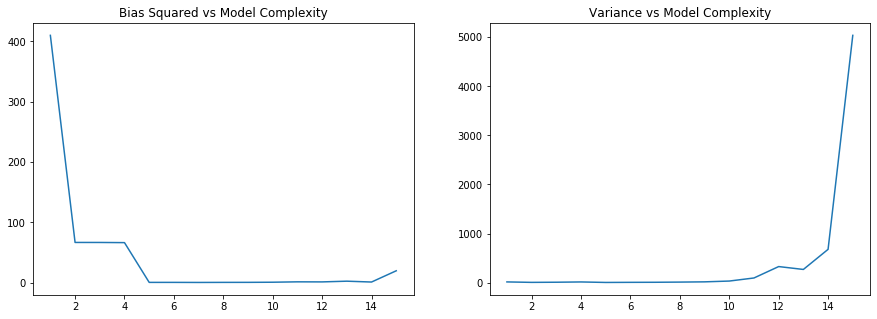

In [19]:
deg = np.arange(1, 16, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(deg, bias_sq)
ax1.set_title("Bias Squared vs Model Complexity")

ax2.plot(deg, variance)
ax2.set_title("Variance vs Model Complexity")

plt.show()

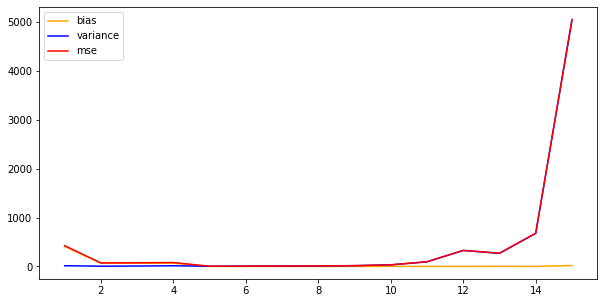

In [20]:
plt.figure(figsize=(10,5))
plt.plot(deg, bias_sq, 'orange', label='bias')
plt.plot(deg, variance, 'blue', label='variance')
plt.plot(deg, mse, 'red', label='mse')
plt.legend()

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

print("Mean squared error: ", mean_squared_error(y_valid, y_pred))

Mean squared error:  458.4478243099991


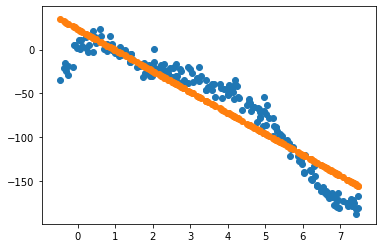

In [24]:
plt.scatter(X_valid, y_valid)
plt.scatter(X_valid, y_pred)
plt.show()

In [26]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

print("Mean squared error: ", mean_squared_error(y_valid, y_pred))

Mean squared error:  59.25758417433044


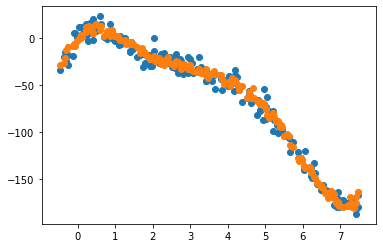

In [27]:
plt.scatter(X_valid, y_valid)
plt.scatter(X_valid, y_pred)
plt.show()

In [28]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

print("Mean squared error: ", mean_squared_error(y_valid, y_pred))

Mean squared error:  100.04652317981116


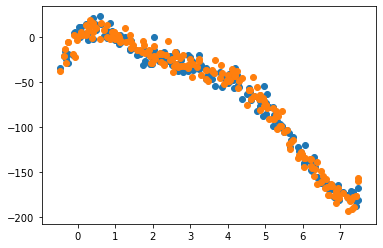

In [29]:
plt.scatter(X_valid, y_valid)
plt.scatter(X_valid, y_pred)
plt.show()

Firstly, to calculate bias, you'll need to know the true values. Above, we used the equation of the line to get the true values. However, for actual datasets, there isn't an equation for us to plug in x values and get y values. If not, there's no need to do machine learning.

Secondly, to calculate bias and variance, we had to run the linear regression model 500 times to get a distribution of 500 y points for each x point. From these 500 points, get the Expectation. For an actual dataset, to do this would be computationally expensive and time consuming. We can only afford to to it here since the data points are less (1,000), and there are only 2 features.